####  Compiling Braket circuits with the Qiskit Braket Provider

In this notebook we show how we can use the [Qiskit-Braket provider](https://github.com/qiskit-community/qiskit-braket-provider/blob/main/docs/tutorials/0_tutorial_qiskit-braket-provider_overview.ipynb) to enhance Braket applications and access features like native compilation ina  straightforward manner. 

>[!IMPORTANT]
>Further details and documentation for using the Qiskit-Braket-Provider can be found at the Qiskit-Braket provider [tutorials](https://github.com/qiskit-community/qiskit-braket-provider/tree/main/docs/tutorials) and [how-to](https://github.com/qiskit-community/qiskit-braket-provider/tree/main/docs/how_tos) pages. 

>[!NOTE]
> if you're running this in your local development environment (i.e. not from the Braket console), you'll need to make sure you've got your AWS account configured properly first to access Braket devices. Check out [this tutorial](https://aws.amazon.com/blogs/quantum-computing/setting-up-your-local-development-environment-in-amazon-braket/) for a walkthrough.

### Why circuit compilation? 

The success of a quantum circuit generally scales with the number of gates. There are also generally infinite ways of expressing the same circuit, and so given many logically equivalent circuits, a simple way to improve our results is to choose representation that have less gates. 

There also are generally constraints given the physical device being used. For instance, we can have differing layouts, physical gate connections, and widely varying error rates. 




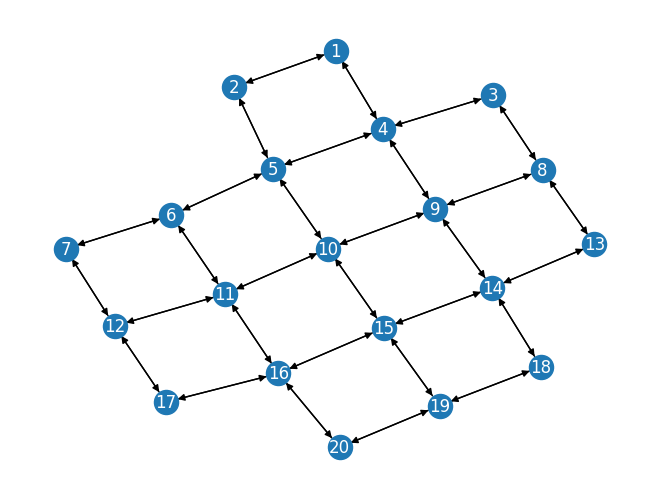

In [1]:
import networkx as nx
from braket.aws import AwsDevice
from braket.devices import Devices
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np

garnet = AwsDevice(Devices.IQM.Garnet)
nx.draw_kamada_kawai(garnet.topology_graph, with_labels=True, font_color="white")

We can see a more detailed picture of physical attributes with some help from the device properties:

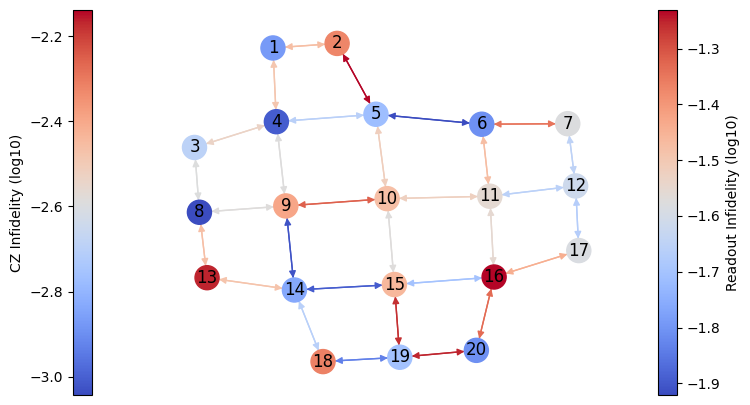

In [2]:

props = garnet.properties.provider.properties
graph_nodes, graph_edges =list(garnet.topology_graph.nodes()), list(garnet.topology_graph.edges())

node_vals = []
for node in graph_nodes:
    node_vals.append(1 - props['one_qubit'][str(node)]['fRO'])

edge_vals = []
for edge in graph_edges:
    if edge[0] > edge[1]:
        edge = (edge[1], edge[0])
    edge_key = f"{edge[0]}-{edge[1]}"
    edge_vals.append(1 - props['two_qubit'][edge_key]['fCZ'])

edge_vals = np.log10(edge_vals)
node_vals = np.log10(node_vals)

fig, ax = plt.subplots(figsize = (10,5))

nx.draw(garnet.topology_graph, 
        node_color=node_vals, 
        edge_color=edge_vals, 
        cmap=cm.coolwarm, 
        edge_cmap=cm.coolwarm, 
        with_labels=True,
        ax = ax)

node_norm = Normalize(vmin=min(node_vals), vmax=max(node_vals))
edge_norm = Normalize(vmin=min(edge_vals), vmax=max(edge_vals))
sm_nodes = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=node_norm)
sm_edges = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=edge_norm)

cbar1 = plt.colorbar(sm_nodes, ax=ax,label='Readout Infidelity (log10)')
cbar2 = plt.colorbar(sm_edges, ax=ax,label='CZ Infidelity (log10)',location='left')

plt.show()


Depsite the somewhat complex visualization, here we see how different gates and qubit chocies can lead to . The success of a particular circuit depends heavily on how the circuit is mapped. 

### Compilation via the Braket Service

As detailed in the [Developer Guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-compiled-circuits-inspecting.html), one way to get the Compiled circuit, is to submit a job, and then return the circuit via the compiled program (which is also accessible on the console). Here we show this for an 8-qubit GHZ circuit:

In [3]:
from braket.circuits import Circuit
ghz = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(2, 3).cnot(3, 4).cnot(4, 5).cnot(5, 6).cnot(6, 7)
print(ghz)



T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │
      ┌───┐                                           
q0 : ─┤ H ├───●───────────────────────────────────────
      └───┘   │                                       
            ┌─┴─┐                                     
q1 : ───────┤ X ├───●─────────────────────────────────
            └───┘   │                                 
                  ┌─┴─┐                               
q2 : ─────────────┤ X ├───●───────────────────────────
                  └───┘   │                           
                        ┌─┴─┐                         
q3 : ───────────────────┤ X ├───●─────────────────────
                        └───┘   │                     
                              ┌─┴─┐                   
q4 : ─────────────────────────┤ X ├───●───────────────
                              └───┘   │               
                                    ┌─┴─┐             
q5 : ───────────────────────────────┤ X ├───●─────────
          

In [4]:
task = garnet.run(ghz, shots=1)
result = task.result()

In [5]:
compiled_circuit = Circuit().from_ir(result.get_compiled_circuit())
print(compiled_circuit)

T   : │        0        │         1         │  2  │         3         │  4  │         5         │  6  │         7         │  8  │         9         │ 10  │        11         │ 12  │        13         │ 14  │        15         │      16       │ 17  │
                         ┌─────────────────┐                                                                                                                                   ┌───┐ ┌─────────────────┐                                           ┌───┐ 
q4  : ───StartVerbatim───┤ PRx(1.57, 4.71) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(1.57, 1.57) ├───●─────────────────────────EndVerbatim───┤ M ├─
               ║         └─────────────────┘                                                                                                                                   └─┬─┘ └─────────────────┘   │                              ║        └───┘ 


### Accessing Circuit Compilation via the Qiskit Braket Provider

In instances where we want to perform many compilation steps, or perhaps know what our circuit looks like before submitting it, we can utilize built-in features of Qiskit (namely the transpiler) to compile the circuit. 

The Qiskit Braket Provider provides pre-configured Backend objects, which populate relevant Qiskit Targets to perform noise-aware and device-aware transpilation. 

In [6]:
from qiskit_braket_provider import AWSBraketBackend, to_braket

backend = AWSBraketBackend(device=garnet)
ghz_garnet = to_braket(ghz, target = backend.target, optimization_level= 3, qubit_labels= backend.qubit_labels)

print(ghz_garnet)

T   : │        0        │         1         │         2         │  3  │         4         │         5         │  6  │         7         │         8         │  9  │        10         │        11         │ 12  │        13         │        14         │ 15  │        16         │        17         │ 18  │        19         │        20         │ 21  │        22         │        23         │      24       │ 25  │
                         ┌─────────────────┐ ┌─────────────────┐                                                                                                                                           ┌───┐ ┌─────────────────┐ ┌─────────────────┐                                                                                                                                                           ┌───┐ 
q3  : ───StartVerbatim───┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_62228/1601154650.py:3: DeprecationWarning: AWSBraketBackend is deprecated. Use BraketAwsBackend instead
  backend = AWSBraketBackend(device=garnet)
/Users/sesmart/coding/development/braket-examples/local/amazon-braket-examples/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:860: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn("The Qiskit circuit contains barrier instructions that are ignored.")
/Users/sesmart/coding/development/braket-examples/local/amazon-braket-examples/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:910: UserWarning: Device does not support global phase; global phase of 4.71238898038469 will not be included in Braket circuit
  warnings.warn(


If instead, we want to perform more granular manipulation, we can directly specify items like `basis_gates`, `connectivity`, `angle_restrictions`, the `optimization_level` of the preset_pass_manager, as well `qubit_labels` that we map the Braket circuit back to. For those more familiar with Qiskit, we can also supply a custom PassManager object. 

>[!Important]
> Verbatim flags will not always be applied to a circuit. These are mainly supplied when a device or target is specified, the verbatim flag is specified, or when a custom PassManger is utilized. To remove measurement, use the `to_qiskit` feature with `add_measurement = False`. 

>[!Note]
> Circuit indexing can also be accomplished via the `target_mapping` keyword in `Circuit().add_circuit`. However, for consistency with the contiguous Qiskit ordering convention, using  `target.qubit_labels` is preferred. 

In [7]:
ghz_basis = to_braket(ghz, basis_gates=["cz","r"]) # no native qubits 
print(ghz_basis) # 

ghz_linear = to_braket(ghz, connectivity = [[5,4],[4,3],[3,2],[2,0],[0,6],[6,1],[1,7]], optimization_level=2) # custom linear layout
print(ghz_linear)


T  : │         0         │         1         │  2  │         3         │         4         │  5  │         6         │         7         │  8  │         9         │        10         │ 11  │        12         │        13         │ 14  │        15         │        16         │ 17  │        18         │        19         │ 20  │        21         │        22         │ 23  │
      ┌─────────────────┐ ┌─────────────────┐                                                                                                                                                                                                                                                                                                                                   ┌───┐ 
q0 : ─┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├───●─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

The `optimization_level` matches the Qisit tranpiler keyword, ad will vary depending on other keywords provided. Given a target or backend, the transpilation will vary from basis set conversion to qubit rerouting to resynthesis of 1 and 2 qubit gates. 

In [8]:

ghz_4 = Circuit().cnot(0,2).cnot(0,1).cnot(2,3)

for opt_level in [0,1,2,3]:
    print(f"Optimization Level: {opt_level}")
    print(to_braket(ghz_4, optimization_level= opt_level, target = backend.target, qubit_labels= backend.qubit_labels))

Optimization Level: 0
T  : │        0        │         1         │         2         │         3         │  4  │         5         │  6  │         7         │         8         │  9  │        10         │        11         │        12         │        13         │        14         │      15       │ 16  │
                                                                                                                                                                                                                                                                                      ┌───┐ 
q1 : ───StartVerbatim─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────●────────────────────────────────────────────────────────────────────────────────────────────EndVerbatim───┤ M ├─
              ║                                                                                                            

/Users/sesmart/coding/development/braket-examples/local/amazon-braket-examples/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:910: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


For this example, the main difference is between levels 0 and 1, though for more complex (and particularly larger) circuits, additional resynthesis and more agressive rerouting can take place. 

### Further Information

The `to_braket` function supports Qiskit QuantumCircuits, as well as functional OpenQASM3 programs. More information and examples can be seen in the related [tutorial](https://qiskit-community.github.io/qiskit-braket-provider/tutorials/5_tutorial_transpilation.html#Transpiling-OpenQASM-3). 